In [136]:
import jax
import jax.numpy as jnp
from itertools import product

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
def get_results(method):
    results = []
    for latent_seed, data_seed in zip(range(200, 220), range(300, 320)):
        results.append(pd.read_pickle(f"results/{method}_{latent_seed}_{data_seed}.pkl"))
    return results

def get_metric(result, metric):
    cols = [f"gen_{ell}_{sigma}_{omega}" for ell, sigma, omega in product(["1", "0"], repeat=3)]
    df = pd.DataFrame(columns = cols, index = map(lambda x: x[4:], cols))
    for col in df:
        YY_test = result[col]["YY_test"]
        YY_clean_test = result[col]["YY_clean_test"]
        for idx in df.index:
            preds = result[col][idx]
            if metric == "rmse":
                df[col][idx] = jnp.sqrt(jnp.mean(jnp.square(preds["pred_mean"].T - YY_test)))
            elif metric == "nlpd":
                means = preds["pred_mean"].T
                pure_var = preds["pred_var"].T
                omegas = preds["pred_omega"].T
                scales = jnp.sqrt(pure_var + omegas**2)
                df[col][idx] = -tfd.Normal(means, scales).log_prob(YY_test).mean()
            elif metric == "mod_nlpd":
                means = preds["pred_mean"].T
                pure_var = preds["pred_var"].T
                pure_scales = jnp.sqrt(pure_var)
                omegas = preds["pred_omega"].T
                scales = jnp.sqrt(pure_var + omegas**2)
                pure_nlpd = -tfd.Normal(means, pure_scales).log_prob(YY_clean_test)
                noise_nlpd = -tfd.Normal(YY_clean_test, omegas).log_prob(YY_test-YY_clean_test)
                df[col][idx] = (pure_nlpd + noise_nlpd).mean()
    return df

def get_rankings(dfs):
    # get rankings for each column
    rankings = []
    for df in dfs:
        rankings.append(df.rank(axis=0))
    return rankings

def convert(df):
    def convert_col(col):
        ell, sigma, omega = col[4:].split("_")
        if ell == sigma == omega == "0":
            return "gen_stat"
        return f"gen_{'l'*int(ell)}{'s'*int(sigma)}{'o'*int(omega)}"
    
    def convert_idx(idx):
        ell, sigma, omega = idx.split("_")
        if ell == sigma == omega == "0":
            return "stat"
        return f"{'l'*int(ell)}{'s'*int(sigma)}{'o'*int(omega)}"
    
    cols = map(convert_col, df.columns)
    idx = map(convert_idx, df.index)
    df.columns = cols
    df.index = idx
    return df

### Metrics

In [141]:
method = "delta_inducing" # delta_inducing, heinonen
metric = "rmse" # rmse, nlpd, mod_nlpd

dfs = list(map(lambda result: get_metric(result, metric), get_results(method)))
ranks = list(map(convert, get_rankings(dfs)))
mean = sum(ranks)/len(ranks)
stds = round((sum(list(map(lambda x: (x-mean)**2, ranks)))/len(ranks)) ** 0.5, 2)
display(mean.astype("str") + " ± " + stds.astype("str"))
mean.rank().astype(int).style.highlight_min(color="green")

,gen_lso,gen_ls,gen_lo,gen_l,gen_so,gen_s,gen_o,gen_stat
lso,4.8 ± 2.46,4.8 ± 2.56,4.3 ± 2.08,4.05 ± 2.56,3.7 ± 2.12,4.9 ± 2.51,3.3 ± 1.68,4.5 ± 1.63
ls,4.35 ± 1.9,4.35 ± 2.5,5.2 ± 2.38,3.9 ± 2.34,4.35 ± 2.24,3.5 ± 2.11,5.7 ± 1.62,5.1 ± 2.28
lo,4.25 ± 2.14,3.4 ± 1.71,3.75 ± 2.23,4.45 ± 2.44,5.0 ± 2.1,5.45 ± 2.04,2.9 ± 1.97,3.4 ± 2.31
l,4.25 ± 2.51,5.0 ± 2.0,4.75 ± 2.38,3.9 ± 1.84,4.8 ± 2.48,4.2 ± 2.23,6.0 ± 1.84,4.65 ± 1.9
so,4.8 ± 2.46,5.0 ± 2.88,3.75 ± 2.23,4.35 ± 2.48,3.8 ± 2.16,4.95 ± 2.48,3.8 ± 1.89,4.75 ± 2.38
s,4.15 ± 2.03,3.65 ± 2.2,5.1 ± 2.43,5.0 ± 2.1,4.55 ± 2.29,4.05 ± 2.29,5.0 ± 2.41,4.9 ± 2.34
o,4.55 ± 2.42,5.0 ± 1.9,3.85 ± 2.17,5.3 ± 1.98,4.5 ± 2.36,4.8 ± 2.01,3.45 ± 2.22,3.15 ± 2.06
stat,4.85 ± 2.2,4.8 ± 1.63,5.3 ± 1.62,5.05 ± 2.01,5.3 ± 2.08,4.15 ± 1.98,5.85 ± 1.9,5.55 ± 2.25


,gen_lso,gen_ls,gen_lo,gen_l,gen_so,gen_s,gen_o,gen_stat
lso,6,4,4,3,1,6,2,3
ls,4,3,7,1,3,1,6,7
lo,2,1,1,5,7,8,1,2
l,2,7,5,1,6,4,8,4
so,6,7,1,4,2,7,4,5
s,1,2,6,6,5,2,5,6
o,5,7,3,8,4,5,3,1
stat,8,4,8,7,8,3,7,8


### Plot

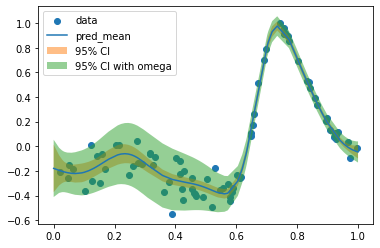

In [142]:
method = "delta_inducing" # delta_inducing, heinonen
idx = 0
gen = "gen_1_1_1"
model = "1_1_1"
test_idx = 1

result = get_results(method)[idx]
gen_data = result[gen]
X = gen_data["XX"][:,:,test_idx]
y = gen_data["YY"][:,test_idx]
X_test = gen_data["XX_test"][:,:,test_idx]
y_test = gen_data["YY_test"][:,test_idx]
preds = gen_data[model]
pred_mean = preds["pred_mean"][test_idx]
pred_var = preds["pred_var"][test_idx]
omega = preds["pred_omega"][test_idx]

sort_idx = jnp.argsort(X_test[:,0])
plt.scatter(X, y, label="data")
plt.plot(X_test[sort_idx], pred_mean[sort_idx], label="pred_mean");
# Plot the 95% confidence interval
plt.fill_between(X_test[sort_idx,0], pred_mean[sort_idx] - 1.96 * jnp.sqrt(pred_var[sort_idx]), pred_mean[sort_idx] + 1.96 * jnp.sqrt(pred_var[sort_idx]), alpha=0.5, label="95% CI")

# Plot the 95% confidence interval with omega
plt.fill_between(X_test[sort_idx,0], pred_mean[sort_idx] - 1.96 * jnp.sqrt(pred_var[sort_idx] + omega[sort_idx]**2), pred_mean[sort_idx] + 1.96 * jnp.sqrt(pred_var[sort_idx] + omega[sort_idx]**2), alpha=0.5, label="95% CI with omega")

plt.legend();

### Comparison

In [134]:
metric = "nlpd" # rmse, nlpd, mod_nlpd
our_dfs = list(map(lambda result: get_metric(result, metric), get_results("delta_inducing")))
heinonen_dfs = list(map(lambda result: get_metric(result, metric), get_results("heinonen")))

diffs = list(map(lambda a, b: a-b, heinonen_dfs, our_dfs))
avg_diff = sum(diffs)/len(diffs)
# highlight positive differences
avg_diff.style.applymap(lambda x: "background-color: green" if x >= 0 else "")

,gen_1_1_1,gen_1_1_0,gen_1_0_1,gen_1_0_0,gen_0_1_1,gen_0_1_0,gen_0_0_1,gen_0_0_0
1_1_1,0.043195132,0.030695831,0.038714506,0.09566377,-0.020995341,0.084959075,0.015349899,0.08490755
1_1_0,-0.035359897,0.050643332,0.2681628,0.05909235,0.082861654,0.051922612,0.2642877,0.09408797
1_0_1,-0.008989458,0.028485764,-0.0019333165,0.05016657,-0.009220397,0.05458979,-0.021637764,0.019215813
1_0_0,-0.026880458,0.0059484313,0.098462574,0.022523282,0.10450759,0.03386333,0.16678174,0.060910206
0_1_1,0.026984269,0.0041893944,0.03727321,0.03238175,0.01809242,0.05398529,-0.0024064044,0.053176116
0_1_0,-0.019277943,0.007549948,0.218093,0.034728058,-0.03236761,0.028695907,-0.040788222,0.03438624
0_0_1,-0.021193583,0.013851473,-0.01750438,0.016974641,-0.0101900175,0.018517418,-0.019514363,0.010464129
0_0_0,0.0047989124,0.0013328365,0.0031918068,0.0029912111,0.011653106,0.0036124617,0.02491877,-0.001433479
